In [1]:
import os
import pandas as pd
import io
import matplotlib.pyplot as plt

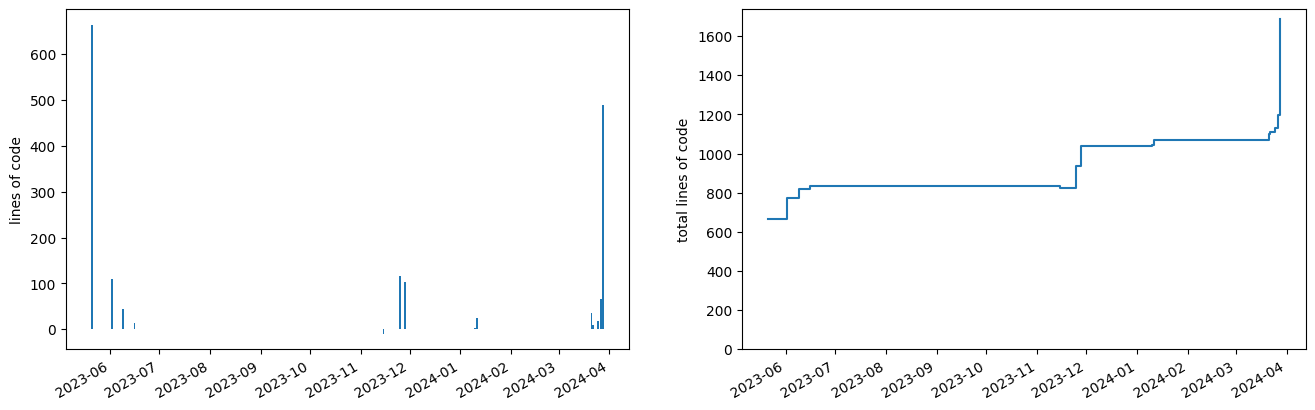

In [2]:
command = os.popen("echo 'date,lines,empty';/home/stefan/bin/gitdatalines '*.tex'")

lines = pd.read_csv(io.StringIO(command.read()), sep=",")[['date', 'lines']]
lines["date"] = pd.to_datetime(lines["date"])
tlines = lines.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(tlines.index, tlines['lines'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("lines of code")

tlines.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total lines of code")
axs[1].set_ylim(0, None)

fig.autofmt_xdate()
plt.show()

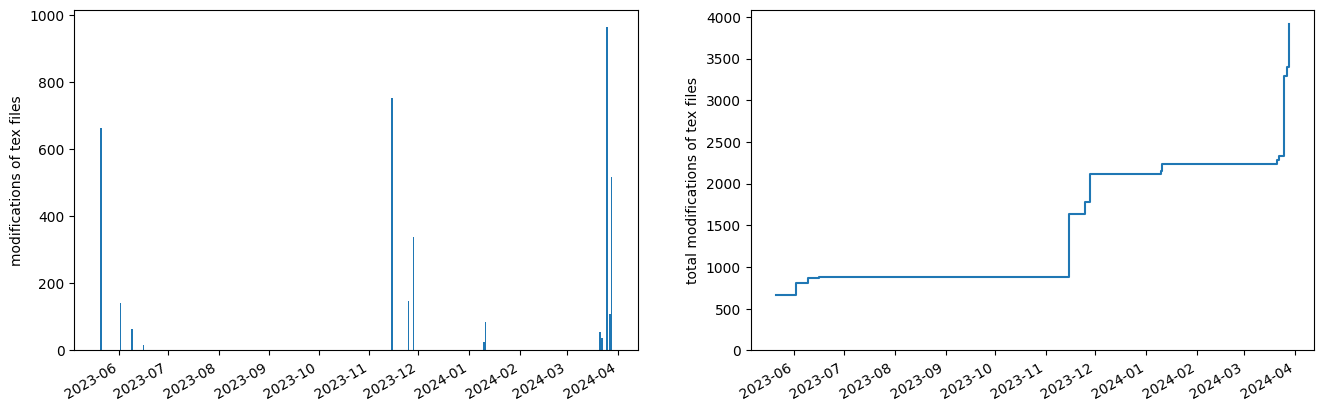

In [3]:
command = os.popen("echo 'date modifications';/home/stefan/bin/gitdatamodifications '*.tex'")
modifications = pd.read_csv(io.StringIO(command.read()), sep=" ")[['date', 'modifications']]
modifications["date"] = pd.to_datetime(modifications["date"])
tmodifications = modifications.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16,5))
axs[0].bar(tmodifications.index, tmodifications['modifications'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("modifications of tex files")

tmodifications.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total modifications of tex files")
axs[1].set_ylim(0, None)
fig.autofmt_xdate()
plt.show()